In [1]:
import sys
import time
import numpy as np
import os.path as osp
import tensorflow as tf
import matplotlib.pyplot as plt

    
from tf_lab.fundamentals.utils import set_visible_GPUs, reset_tf_graph

import tf_lab.point_clouds.in_out as pio
from tf_lab.point_clouds.in_out import PointCloudDataSet, write_model_ids_of_datasets
from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder
from tf_lab.point_clouds.autoencoder import Configuration as Conf
import tf_lab.point_clouds.encoders_decoders as enc_dec


import tf_lab.autopredictors.scripts.virt_scan_data as vscan

from tf_lab.autopredictors.scripts.helper import shape_net_category_to_synth_id, points_extension, \
                                                 shape_net_core_synth_id_to_category

from tf_lab.autopredictors.scripts import minhyuk_data

from tf_lab.autopredictors.plotting import plot_original_pclouds_vs_reconstructed, \
                                           plot_train_val_test_curves, plot_reconstructions_at_epoch
        
from tf_lab.autopredictors.evaluate import eval_model, read_saved_epochs, accuracy_of_completion, \
                                           coverage_of_completion, save_reconstructions, \
                                           save_pc_prediction_stats
                                                  

from general_tools.in_out.basics import create_dir, delete_files_in_directory, files_in_subdirs
from general_tools.simpletons import select_first_last_and_k
from geo_tool import Point_Cloud

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/orions4-zfs/projects/lins2/Panos_Space/Git_Repos/geo_tool/solids/mesh.py:26: UserWarning: Mayavi library was not found. Some graphics utilities will be disabled.
  warnings.warn('Mayavi library was not found. Some graphics utilities will be disabled.')


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [6]:
incomplete_n_samples = 2048
complete_n_samples = 4096

test_data, accuracies = minhyuk_data.dataset_of_category(4)

class_type = raw_input('Give me the class type.\n').lower()
class_syn_id = shape_net_category_to_synth_id()[class_type]

GPU = 0
exp_counter = '4'
loss = 'chamfer'
load_model_conf = True

experiment_name = exp_counter + '_' + class_type + '_' + str(incomplete_n_samples) + '_' \
                  + str(complete_n_samples) + 'pts_' + loss

top_data_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/'
train_dir = osp.join(top_data_dir, 'OUT/models/incomplete_pclouds/paper_vanilla_vscan')
train_dir = osp.join(train_dir, experiment_name)

shapenet_tables
Give me the class type.
table


In [15]:
keep_mask = np.array(accuracies) >= .99

0.99951171875


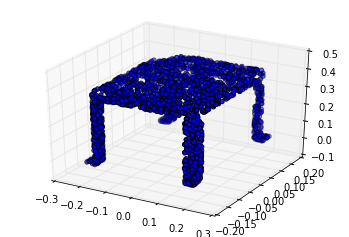

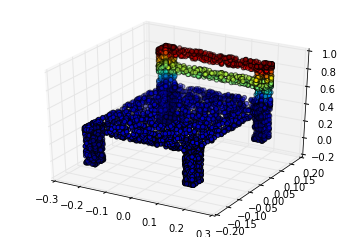

['coseg_chairs.2']


In [191]:
pp = test_data.next_batch(1)
pinc = pp[2].reshape(incomplete_n_samples, 3)
pcom = pp[0].reshape(complete_n_samples, 3)
        
score1 = accuracy_of_completion(pinc, pcom, 0.02, ret_dists=False)
print score1
score2, c2 = coverage_of_completion(pcom, pinc, 0.02, ret_dists=True)

Point_Cloud(points=pinc).plot();
Point_Cloud(points=pcom).plot(c=c2);
print pp[1]

In [16]:
if load_model_conf:
    conf = Conf.load(osp.join(train_dir, 'configuration'))
    conf.consistent_io = None
    conf.encoder_args = {'dropout_prob': 1}
    print conf
else:
    decoder_args = {'layer_sizes': [1024, np.prod(n_output)],
                    'non_linearity': tf.nn.relu
                   }

    encoder_args = {'dropout_prob': 0.5}
    
    conf = Conf(
                n_input = n_input,
                n_output = n_output,
                denoising = True,
                training_epochs = max_training_epochs,
                batch_size = 50,
                loss = loss,
                train_dir = train_dir,
                loss_display_step = 1,
                saver_step = 2,
                learning_rate = 0.0005,
                encoder = enc_dec.encoder_with_convs_and_symmetry,
                encoder_args = encoder_args,
                decoder = enc_dec.decoder_with_fc_only,
                decoder_args = decoder_args
               )
    
    conf.experiment_name = experiment_name
    conf.save(osp.join(conf.train_dir, 'configuration'))
    
reset_tf_graph()
set_visible_GPUs([GPU])
ae = PointNetAutoEncoder(experiment_name, conf)

                    batch_size: 50
                 consistent_io: False
                         debug: False
                       decoder: decoder_with_fc_only
                  decoder_args: {'non_linearity': <function relu at 0x7fd01c01de60>, 'layer_sizes': [1024, 12288]}
                       encoder: encoder_with_convs_and_symmetry
                  encoder_args: {'dropout_prob': 0.5}
               experiment_name: 4_table_2048_4096pts_chamfer
                 gauss_augment: None
                  is_denoising: True
               latent_vs_recon: 1.0
                 learning_rate: 0.0005
                          loss: chamfer
             loss_display_step: 1
                       n_input: [2048, 3]
                      n_output: [4096, 3]
                           n_z: None
             saver_max_to_keep: None
                    saver_step: 2
                     train_dir: /orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/incomplete_pclouds/paper_vanilla_vscan/

In [59]:
pc, l, pci = test_data.full_epoch_data()



# def z_rotation_by_theta(theta):
#     cos_t = np.cos(theta);
#     sin_t = np.sin(theta)
#     R = np.array([[cos_t, -sin_t, 0], 
#                   [sin_t, cos_t, 0],
#                   [0, 0, 1]]
#                 )
#     return R
        

# R = z_rotation_by_theta((-90 /180.0) * np.pi)

# l2_norm =  np.linalg.norm

for i in xrange(len(pc)):
#     pc[i] = Point_Cloud(points=pc[i]).permute_points([0,2,1]).points
    
#     pc[i] = pc[i].dot(R)        
#     pci[i] = pci[i].dot(R)
    mu = np.mean(pc[i], axis=0)
    pc[i] -= mu
    pci[i] -= mu
    
    max_dist = np.max(l2_norm(pc[i], axis=1))  # Make max distance equal to one.
    if max_dist > 0.5:
        pc[i] /= max_dist * 2
        pci[i] /= max_dist * 2
    


#     pc[i,:,2] = pc[i,:,2] - 0.5


# for i in xrange(len(pci)):    
#     pci[i,:,2] = pci[i,:,2] - 0.5


# # # for i in xrange(len(pc)):
# # #     pc[i,:,2] = pc[i,:,2] - 0.5
    
# # # for i in xrange(len(pci)):
# # #     pci[i,:,1] = -pci[i,:,1]

# # # # Point_Cloud(points=pci[4]).permute_points([1,0,2]).plot()


test_data_2 = PointCloudDataSet(pc, labels=l, noise=pci)

# a_pc = pc[10]
# Point_Cloud(points=).plot()


In [60]:
do_evaluation = True

if do_evaluation:    
#     best_epoch = 46      
#     ae.restore_model(conf.train_dir, best_epoch, verbose=True)    
    top_save_dir = osp.join(conf.train_dir, 'output', 'epoch_' + str(best_epoch))
    save_dir = osp.join(top_save_dir, 'test_predictions')    
    test_recon, test_loss, test_feed, test_ids, test_gt = ae.evaluate(test_data_2, conf)
#     save_reconstructions(save_dir, test_recon, test_gt, test_feed, test_ids) # save ply files of test data.    
#     train_loss = ae.evaluate(train_data, conf)[1]
    
    # Report Accuracy and Coverage of test data.
    n_examples = len(test_recon)
    pred_scores = np.zeros((n_examples, 2))
    for i in xrange(n_examples):
        gt = test_gt[i]
        pred = test_recon[i] 
        pred_scores[i, 0] = accuracy_of_completion(pred, gt, thres=0.02, ret_dists=False)
        pred_scores[i, 1] = coverage_of_completion(gt, pred, thres=0.02, ret_dists=False)
    
    print 'Test Median-Accuracy-Coverage:', np.median(pred_scores[:, 0]), np.median(pred_scores[:, 1])
        
#     save_pc_prediction_stats(osp.join(top_save_dir, 'detailed_stats.txt'), test_ids, pred_scores)
    
#     with open(osp.join(top_save_dir, 'stats.txt'), 'w') as fout:
#         fout.write('Best Validation Epoch = %d\n' % (best_epoch))
#         fout.write('Validation loss = %f\n' % (val_loss))
#         fout.write('Train loss = %f\n' % (train_loss))
#         fout.write('Test loss = %f\n' % (test_loss))
#         fout.write('Gen. Error (abs, per) = %f %f\n' % (abs(test_loss-train_loss),  abs(test_loss-train_loss) / train_loss ))
#         fout.write('Test Median-Accuracy-Coverage = %f %f\n' % (np.median(pred_scores[:, 0]), np.median(pred_scores[:, 1])))
#         fout.write('Test Median Harmonic Mean = %f' % (np.median(hmean(pred_scores, 1))))

Test Median-Accuracy-Coverage: 0.068603515625 0.31494140625


In [74]:
for i in xrange(len(test_feed)):
    print coverage_of_completion(Point_Cloud.center_points_in_unit_sphere(test_gt[i]), Point_Cloud.center_points_in_unit_sphere(test_recon[i]), thres=0.02, ret_dists=False)

0.37646484375
0.0615234375
0.429931640625
0.457275390625
0.28173828125
0.381591796875
0.27783203125
0.363525390625
0.30322265625
0.4248046875
0.2265625
0.33349609375
0.279052734375
0.1904296875
0.162353515625
0.402587890625
0.35791015625
0.14013671875
0.08203125
0.30517578125
0.143798828125
0.1416015625
0.251708984375
0.318359375
0.297607421875
0.135986328125
0.53466796875
0.329345703125
0.306640625
0.3359375
0.057861328125
0.125
0.15673828125
0.231689453125
0.238525390625
0.375732421875
0.28125


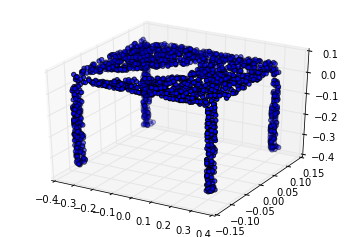

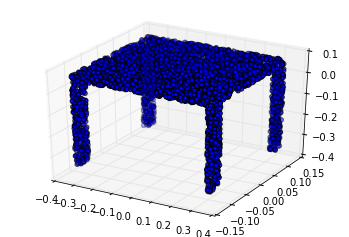

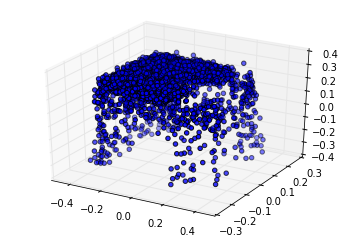

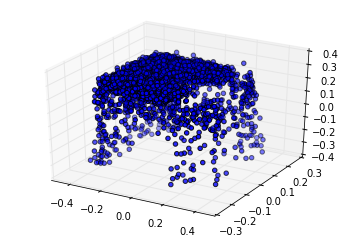

In [58]:
k = 2
Point_Cloud(points=test_feed[k]).plot()
Point_Cloud(points=test_gt[k]).plot()
Point_Cloud(points=test_recon[k]).plot()

In [39]:
import tf_lab.point_clouds.in_out as pio
top_data_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/'
complete_pclouds_path = osp.join(top_data_dir, 'ShapeNetPointClouds/from_manifold_meshes/not_scaled', \
                             str(complete_n_samples), class_syn_id)

cmpl_file_names = pio.load_filenames_of_input_data(complete_pclouds_path, 'pts.txt')
cmpl_pclouds, cmpl_model_names, syn_ids = pio.load_crude_point_clouds(file_names=cmpl_file_names, n_threads=30)
assert(len(np.unique(syn_ids)) == 1)
print '%d files containing complete point clouds were found.' % (len(cmpl_pclouds), )

8509 files containing complete point clouds were found.


In [40]:
v_scan_top_dir = osp.join(top_data_dir, 'From_Matthias/shapenet_dim32_sdf_pc', class_syn_id)
    
test_id_file = osp.join(top_data_dir, 'From_Matthias/train_test_models/test_models_with_scan_id.txt')
vscan_test_data = vscan.load_single_class_incomplete_dataset(v_scan_top_dir, test_id_file, class_syn_id,
                                                      cmpl_pclouds, cmpl_model_names, n_threads=40,
                                                      n_samples=incomplete_n_samples)

6000 incomplete point clouds were loaded.
